In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import imblearn
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler


from keras.utils.all_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras import losses, metrics
from keras.wrappers.scikit_learn import KerasClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/dish-network-hackathon/Sample_Submission.csv
/kaggle/input/dish-network-hackathon/Data_Dictionary.csv
/kaggle/input/dish-network-hackathon/Train_Dataset.csv
/kaggle/input/dish-network-hackathon/Test_Dataset.csv


In [2]:
df = pd.read_csv("/kaggle/input/dish-network-hackathon/Train_Dataset.csv", low_memory=False)
df.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,...,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,...,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,...,Yes,Yes,Self-employed,NaN,0.552795,0.329655054,0.0742,277.0,0.0,0
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,...,Yes,Yes,XNA,NaN,0.135182,0.631354537,NaN,1700.0,3.0,0
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,...,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355638717,0.2021,674.0,1.0,0


In [3]:
# this is a generic function to fix values based on a map passed

def fix_value_by_map(current_value, default, value_map):
    if str(current_value) == 'nan':
        return value_map[default]
    else:
        return current_value

In [4]:
# this is generic function converting to float

def get_floats(values):
    vals = []
    for v in values:
        try:
            vals.append(float(v))
        except:
            vals.append(np.nan)
    return vals

# this is generic function converting to int

def get_integers(values):
    vals = []
    for v in values:
        try:
            vals.append(int(v))
        except:
            vals.append(np.nan)
    return vals

In [5]:
# check for dtypes

# most of data is imported as object and needs to be converted to numeric
df.dtypes

ID                              int64
Client_Income                  object
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                  object
Loan_Annuity                   object
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative     object
Age_Days                       object
Employed_Days                  object
Registration_Days              object
ID_Days                        object
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation              object
Client_Famil

In [6]:
#fix Client_Income

# convert to float
df['Client_Income'] = get_floats(df.Client_Income)
        
# replace nan with proper values
value_map = df.groupby('Default').median()['Client_Income']
df['Client_Income'] = df.apply(lambda row : fix_value_by_map(row['Client_Income'], row['Default'], value_map), axis=1)

In [7]:
# fix Credit_Amount

# convert to float
df['Credit_Amount'] = get_floats(df.Credit_Amount)
        
# remove rows where there is no the amount of the credit
df.dropna(subset=['Credit_Amount'], inplace = True)

In [8]:
# fix Loan_Annuity

# convert to float
df['Loan_Annuity'] = get_floats(df.Loan_Annuity)

# try to get a picture of loan annuity for nan, based on client income and default
value_map = df.groupby(['Client_Income','Default']).mean()['Loan_Annuity']


def get_Loan_Annuity_by_Client_Income_and_Default(loan_annuity, client_income, default, value_map):
    
    new_loan_annuity = loan_annuity
    
    if str(new_loan_annuity) == 'nan':
        for key in value_map.keys():
            if default == key[1]:
                if client_income < key[0]:
                    continue
                else:
                    new_loan_annuity = value_map[key]
                    break
            else:
                continue
    return new_loan_annuity
          
df['Loan_Annuity'] = df.apply(lambda row : get_Loan_Annuity_by_Client_Income_and_Default(row['Loan_Annuity'], row['Client_Income'], row['Default'], value_map), axis=1)

In [9]:
# fix Accompany_Client
df[['Accompany_Client']] = df[['Accompany_Client']].fillna("Alone")

encoder = LabelEncoder()

df.Accompany_Client = encoder.fit_transform(df.Accompany_Client)

In [10]:
# fix Client_Income_Type
df[['Client_Income_Type']] = df[['Client_Income_Type']].fillna("Unknown")

encoder = LabelEncoder()

df.Client_Income_Type = encoder.fit_transform(df.Client_Income_Type)          

In [11]:
# fix Car_Owned: consider nan as no car

df[['Car_Owned']] = df[['Car_Owned']].fillna(value=0)

In [12]:
# fix Bike_Owned: consider nan as no bike

df[['Bike_Owned']] = df[['Bike_Owned']].fillna(value=0)

In [13]:
# fix Active_Loan: consider nan as no active loan

df[['Active_Loan']] = df[['Active_Loan']].fillna(value=0)

In [14]:
# fix House_Own: consider nan as no house owned

df[['House_Own']] = df[['House_Own']].fillna(value=0)

In [15]:
# fix Child_Count: consider nan as no house owned

df[['Child_Count']] = df[['Child_Count']].fillna(value=0)

In [16]:
# fix Client_Education
df[['Client_Education']] = df[['Client_Education']].fillna(value='None')

encoder = LabelEncoder()

df.Client_Education = encoder.fit_transform(df.Client_Education)  

In [17]:
# fix Client_Marital_Status
df[['Client_Marital_Status']] = df[['Client_Marital_Status']].fillna(value='Other')

encoder = LabelEncoder()

df.Client_Marital_Status = encoder.fit_transform(df.Client_Marital_Status)  

In [18]:
# fix Client_Gender
df[['Client_Gender']] = df[['Client_Gender']].fillna(value='Unknown')

encoder = LabelEncoder()

df.Client_Gender = encoder.fit_transform(df.Client_Gender)  

In [19]:
# fix Loan_Contract_Type
df[['Loan_Contract_Type']] = df[['Loan_Contract_Type']].fillna(value='Other')
encoder = LabelEncoder()

df.Loan_Contract_Type = encoder.fit_transform(df.Loan_Contract_Type)  

In [20]:
#fix Client_Housing_Type
df[['Client_Housing_Type']] = df[['Client_Housing_Type']].fillna(value='Other')

encoder = LabelEncoder()

df.Client_Housing_Type = encoder.fit_transform(df.Client_Housing_Type)  

In [21]:
# fix Population_Region_Relative
df['Population_Region_Relative'] = get_floats(df.Population_Region_Relative)

df[['Client_Housing_Type']] = df[['Client_Housing_Type']].fillna(value=0)

encoder = LabelEncoder()

df.Population_Region_Relative = encoder.fit_transform(df.Population_Region_Relative)  

In [22]:
# fix Age_Days
df['Age_Days'] = get_integers(df.Age_Days)
        
# map missing ages by 'default' column 
value_map = df.groupby('Default').median()['Age_Days']
df['Age_Days'] = df.apply(lambda row : fix_value_by_map(row['Age_Days'], row['Default'], value_map), axis=1)

In [23]:
# fix Employed_Days
df['Employed_Days'] = get_integers(df.Employed_Days)

# map missing Employed Days by 'default' column
value_map = df.groupby('Default').median()['Employed_Days']
df['Employed_Days'] = df.apply(lambda row : fix_value_by_map(row['Employed_Days'], row['Default'], value_map), axis=1)

In [24]:
#fix Registration_Days
df['Registration_Days'] = get_integers(df.Registration_Days)

# map missing Registration Days by 'default' column
value_map = df.groupby('Default').median()['Registration_Days']
df['Registration_Days'] = df.apply(lambda row : fix_value_by_map(row['Registration_Days'], row['Default'], value_map), axis=1)

In [25]:
#fix ID_Days
df['ID_Days'] = get_integers(df.ID_Days)
        
# map missing Id Days by 'default' column
value_map = df.groupby('Default').median()['ID_Days']
df['ID_Days'] = df.apply(lambda row : fix_value_by_map(row['ID_Days'], row['Default'], value_map), axis=1)

In [26]:
# fix Client_Occupation
df[['Client_Occupation']] = df[['Client_Occupation']].fillna(value='Other')

encoder = LabelEncoder()

df.Client_Occupation = encoder.fit_transform(df.Client_Occupation)  

In [27]:
# fix Client_Permanent_Match_Tag
encoder = LabelEncoder()

df.Client_Permanent_Match_Tag = encoder.fit_transform(df.Client_Permanent_Match_Tag)  
df.Client_Permanent_Match_Tag.unique()

array([1, 0])

In [28]:
# fix Own_House_Age

# remove for now due to high nans
df.drop(['Own_House_Age'], inplace=True, axis=1)

In [29]:
# fix family members

# suppose nan means zero
df[['Client_Family_Members']] = df[['Client_Family_Members']].fillna(value=0)

In [30]:
#fix Cleint_City_Rating

value_map = df.groupby('Default').median()['Cleint_City_Rating']

df['Cleint_City_Rating'] = df.apply(lambda row : fix_value_by_map(row['Cleint_City_Rating'], row['Default'], value_map), axis=1)

In [31]:
# fix Application_Process_Day

value_map = df.groupby('Default').median()['Application_Process_Day']

df['Application_Process_Day'] = df.apply(lambda row : fix_value_by_map(row['Application_Process_Day'], row['Default'], value_map), axis=1)

In [32]:
# fix Application_Process_Hour

value_map = df.groupby('Default').median()['Application_Process_Hour']

df['Application_Process_Hour'] = df.apply(lambda row : fix_value_by_map(row['Application_Process_Hour'], row['Default'], value_map), axis=1)

In [33]:
# fix Client_Contact_Work_Tag
encoder = LabelEncoder()

df.Client_Contact_Work_Tag = encoder.fit_transform(df.Client_Contact_Work_Tag)  

In [34]:
# fix Type organization by splitting between sector and type
df.Type_Organization.unique()

def get_sector(organization_plus_type_value):
    return str(organization_plus_type_value).lower().split('type')[0]

def get_sector_type(organization_plus_type_value):
    try:
        return int(str(organization_plus_type_value).lower().split('type')[1])
    except:
        return 0

    
# TODO eventually try to join 'XNA' with 'nan' and/or 'Other'?

df['Employment_Sector'] = df.apply(lambda row : get_sector(row['Type_Organization']), axis=1)
df['Employment_Sector_Type'] = df.apply(lambda row : get_sector_type(row['Type_Organization']), axis=1)
df.drop(['Type_Organization'], inplace=True, axis=1)

encoder = LabelEncoder()

df['Employment_Sector'] = encoder.fit_transform(df['Employment_Sector'])

In [35]:
#fix Score_Source_1

df['Score_Source_1'] = get_floats(df.Score_Source_1)

value_map = df.groupby('Default').median()['Score_Source_1']

df['Score_Source_1'] = df.apply(lambda row : fix_value_by_map(row['Score_Source_1'], row['Default'], value_map), axis=1)

In [36]:
#fix Score_Source_2

df['Score_Source_2'] = get_floats(df.Score_Source_2)

value_map = df.groupby('Default').median()['Score_Source_2']

df['Score_Source_2'] = df.apply(lambda row : fix_value_by_map(row['Score_Source_2'], row['Default'], value_map), axis=1)

In [37]:
#fix Score_Source_3

df['Score_Source_3'] = get_floats(df.Score_Source_3)

value_map = df.groupby('Default').median()['Score_Source_3']

df['Score_Source_3'] = df.apply(lambda row : fix_value_by_map(row['Score_Source_3'], row['Default'], value_map), axis=1)

In [38]:
# fix Social_Circle_Default
value_map = df.groupby('Default').mean()['Social_Circle_Default']

df['Social_Circle_Default'] = df.apply(lambda row : fix_value_by_map(row['Social_Circle_Default'], row['Default'], value_map), axis=1)

In [39]:
# fix Phone_Change
value_map = df.groupby('Default').median()['Phone_Change']

df['Phone_Change'] = df.apply(lambda row : fix_value_by_map(row['Phone_Change'], row['Default'], value_map), axis=1)

In [40]:
# fix Credit_Bureau
value_map = df.groupby('Default').median()['Credit_Bureau']

df['Credit_Bureau'] = df.apply(lambda row : fix_value_by_map(row['Credit_Bureau'], row['Default'], value_map), axis=1)

In [41]:
# check all dtypes are fine
df.dtypes

ID                              int64
Client_Income                 float64
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                 float64
Loan_Annuity                  float64
Accompany_Client                int64
Client_Income_Type              int64
Client_Education                int64
Client_Marital_Status           int64
Client_Gender                   int64
Loan_Contract_Type              int64
Client_Housing_Type             int64
Population_Region_Relative      int64
Age_Days                      float64
Employed_Days                 float64
Registration_Days             float64
ID_Days                       float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation               int64
Client_Family_Members         float64
Cleint_City_

In [42]:
# check for nan : we should not have any of them now...
df.isna().sum()

ID                            0
Client_Income                 0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Child_Count                   0
Credit_Amount                 0
Loan_Annuity                  0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Population_Region_Relative    0
Age_Days                      0
Employed_Days                 0
Registration_Days             0
ID_Days                       0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Client_Occupation             0
Client_Family_Members         0
Cleint_City_Rating            0
Application_Process_Day       0
Application_Process_Hour      0
Client_Permanent_Match_Tag    0
Client_Contact_Work_Tag       0
Score_So

In [43]:
# dataset in unbalanced
df.groupby('Default').count()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Employment_Sector,Employment_Sector_Type
Default,,,,,,,,,,,,,,,,,,,,,
0,108649,108649,108649,108649,108649,108649,108649,108649,108649,108649,...,108649,108649,108649,108649,108649,108649,108649,108649,108649,108649
1,9570,9570,9570,9570,9570,9570,9570,9570,9570,9570,...,9570,9570,9570,9570,9570,9570,9570,9570,9570,9570


In [44]:
# oversample the dataset

X = df.drop(['ID','Default'], axis=1)
Y = df.Default

# oversample dataset
oversample = RandomOverSampler(sampling_strategy='minority', random_state=0)
X_over, y_over = oversample.fit_resample(X, Y)

scaler = StandardScaler()
X_over = scaler.fit_transform(X_over)

len(X_over)

217298

In [45]:
# generate train test and validation set

X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.2, stratify=y_over, shuffle=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, shuffle=True, random_state=42)

# transform y to categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_valid = to_categorical(y_valid, 2)

In [46]:
# compose the NN model

model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
model.fit(X_train, y_train, batch_size = 256,  epochs = 80, verbose = True, 
          validation_data=(X_test, y_test), shuffle=True)    
# Evaluate the model accuracy on the validation set.
score = model.evaluate(X_valid, y_valid, verbose=0)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/80
476/476 [==============================] - 4s 6ms/step - loss: 0.4487 - auc: 0.8766 - val_loss: 0.3466 - val_auc: 0.9257
Epoch 2/80
476/476 [==============================] - 3s 6ms/step - loss: 0.3234 - auc: 0.9347 - val_loss: 0.2949 - val_auc: 0.9446
Epoch 3/80
476/476 [==============================] - 3s 6ms/step - loss: 0.2815 - auc: 0.9493 - val_loss: 0.2663 - val_auc: 0.9550
Epoch 4/80
476/476 [==============================] - 3s 7ms/step - loss: 0.2551 - auc: 0.9580 - val_loss: 0.2509 - val_auc: 0.9585
Epoch 5/80
476/476 [==============================] - 3s 6ms/step - loss: 0.2305 - auc: 0.9653 - val_loss: 0.2270 - val_auc: 0.9662
Epoch 6/80
476/476 [==============================] - 3s 6ms/step - loss: 0.2076 - auc: 0.9716 - val_loss: 0.2077 - val_auc: 0.9705
Epoch 7/80
476/476 [==============================] - 3s 6ms/step - loss: 0.1877 - auc: 0.9764 - val_loss: 0.1953 - val_auc: 0.9731
Epoch 8/80
476/476 [==============================] - 3s 6ms/step - loss: 0.

In [47]:
# predict for train and validation (will be used later for confusion matrix)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_valid_pred = model.predict(X_valid)

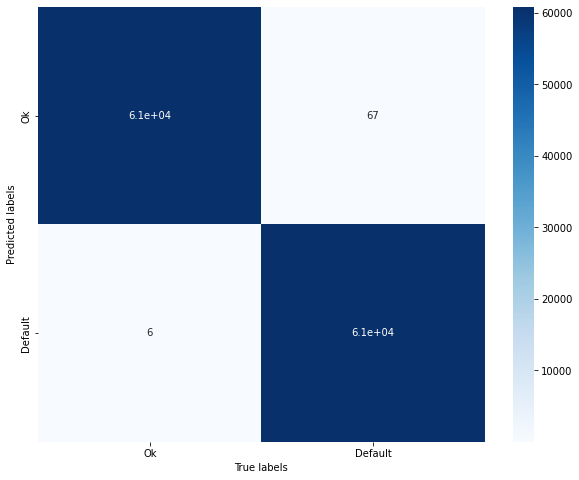

In [48]:
# plot confusion matrix train TRAIN

y_train_for_cmatrix = []
y_train_preds_for_cmatrix = []
for v in y_train:
    if v[1] > 0.5:
        y_train_for_cmatrix.append(1)
    else:
        y_train_for_cmatrix.append(0)
for v in y_train_pred:
    if v[1] > 0.5:
        y_train_preds_for_cmatrix.append(1)
    else:
        y_train_preds_for_cmatrix.append(0)

        
confusion_mtx = confusion_matrix(y_train_for_cmatrix, y_train_preds_for_cmatrix)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, xticklabels=list(['Ok','Default']), yticklabels=list(['Ok','Default']),annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

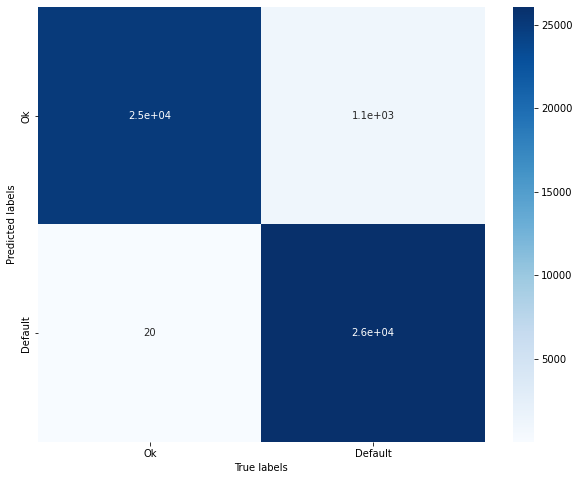

In [49]:
# plot confusion matrix train TEST

y_test_for_cmatrix = []
y_test_preds_for_cmatrix = []
for v in y_test:
    if v[1] > 0.5:
        y_test_for_cmatrix.append(1)
    else:
        y_test_for_cmatrix.append(0)
for v in y_test_pred:
    if v[1] > 0.5:
        y_test_preds_for_cmatrix.append(1)
    else:
        y_test_preds_for_cmatrix.append(0)

        
confusion_mtx = confusion_matrix(y_test_for_cmatrix, y_test_preds_for_cmatrix)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, xticklabels=list(['Ok','Default']), yticklabels=list(['Ok','Default']),annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

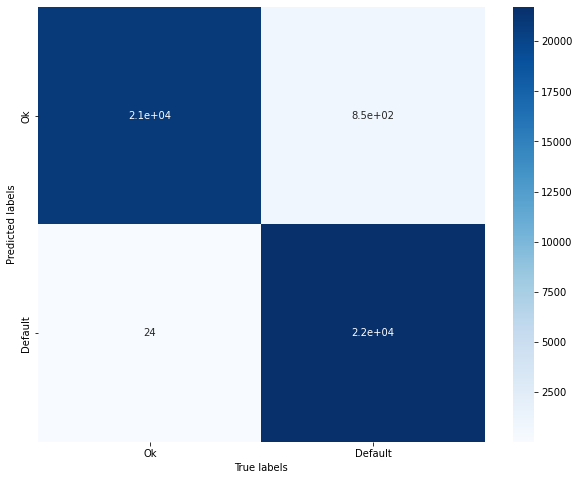

In [50]:
# plot confusion matrix train VALIDATION (data never seen by the algorithm)

y_valid_for_cmatrix = []
y_valid_preds_for_cmatrix = []
for v in y_valid_pred:
    if v[1] > 0.5:
        y_valid_preds_for_cmatrix.append(1)
    else:
        y_valid_preds_for_cmatrix.append(0)
for v in y_valid:
    if v[1] > 0.5:
        y_valid_for_cmatrix.append(1)
    else:
        y_valid_for_cmatrix.append(0)
        
confusion_mtx = confusion_matrix(y_valid_for_cmatrix,y_valid_preds_for_cmatrix)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, xticklabels=list(['Ok','Default']), yticklabels=list(['Ok','Default']),annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [51]:
# print accuracy and f1 score for training data
print(accuracy_score(y_train_for_cmatrix, y_train_preds_for_cmatrix), f1_score(y_train_for_cmatrix, y_train_preds_for_cmatrix))
# print accuracy and f1 score for test data
print(accuracy_score(y_test_for_cmatrix, y_test_preds_for_cmatrix), f1_score(y_test_for_cmatrix, y_test_preds_for_cmatrix))
# print accuracy and f1 score for validation data
print(accuracy_score(y_valid_for_cmatrix, y_valid_preds_for_cmatrix), f1_score(y_valid_for_cmatrix, y_valid_preds_for_cmatrix))

0.9994000953273179 0.999400395902979
0.9788119343457585 0.979235958434335
0.9798895536125173 0.9802646434539132


COMMENTS
This is a base notebook (no tuning, very basic feature engineering
Confusion matrix is quite balanced, but the
behavior of this model for False Negative (risk of default predicted as fine) is worst than False positive ( no risk predicted as default).
To be improved.